In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread, imsave
import cv2
import os
import seaborn as sns

# Métrica
from sklearn.metrics import jaccard_score


## Segmentación

Para comenzar, se definen funciones auxiliares. La primera es *get_closest_component*, la cual toma la componente conexa con area mayor o igual a *area_threshold* más cercana al centro.

In [2]:
def get_closest_component(thresh, area_threshold):
    # Se ejecuta la función connectedComponentsWithStats
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh.astype(np.uint8))

    # Se calcula el centro de la imagen
    height, width = thresh.shape[:2]
    center_x = width // 2
    center_y = height // 2

    # Se inicializan variables para almacenar la componente conexa más cercana y su área
    min_distance = float('inf')
    closest_label = None
    max_area = 0

    # Iterar sobre cada componente conexa (excluyendo el fondo)
    for label in range(1, num_labels):
        # Se obtiene el centroide y el área del componente conexa actual
        centroid_x, centroid_y = centroids[label]
        area = stats[label, cv2.CC_STAT_AREA]

        # Se calcula la distancia desde el centroide actual al centro de la imagen
        distance = np.sqrt((centroid_x - center_x) ** 2 + (centroid_y - center_y) ** 2)

        # Se verifica si el componente conexa cumple las condiciones
        if distance < min_distance and area > area_threshold:
            min_distance = distance
            closest_label = label
            max_area = area

    # Se crea una imagen para almacenar la componente conexa más cercana
    closest_component = np.zeros_like(thresh)

    # Finalmente, se define solamente la componente conexa
    if closest_label is not None:
        closest_component[labels == closest_label] = 255

    return closest_component

A continuación se define la función *detector_blobs*, la cual inicializa el detector de "blobs" y los detecta en la imagen. A la función se le pasa el area mínima del "blob".

In [3]:
def detector_blobs(img_borde,area):
    params = cv2.SimpleBlobDetector_Params()

    params.minThreshold = 10
    params.maxThreshold = 200

    params.filterByArea = True
    params.minArea = area
    params.maxArea = 100000000

    params.filterByCircularity = True
    params.minCircularity = 0.1
    params.maxCircularity = 1

    params.filterByConvexity = True
    params.minConvexity = 0.87
    params.maxConvexity = 1

    params.filterByInertia = True
    params.minInertiaRatio = 0.01
    params.maxInertiaRatio = 1

    detector = cv2.SimpleBlobDetector_create(params) # Defino el detector
    kp = detector.detect(img_borde) # Detecta los blobs

    # Retorna los blobs detectados
    return kp

Finalmente, se define la función de segmentación.

In [4]:
def segmentar(img,borde=60,diam_por=1.45,cantidad_blanco=0.9,num_er=5,delta_dil=8,num_dil=11,area_component=7500,area_blob=90000):
    dim_img = img.shape # Dimensiones de la imagen
    img_g = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # Paso la imagen a escala de grises

    ret,img_th = cv2.threshold(img_g,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU) # Aplico segmentación basada en Otsu

    # En algunas imagenes se observo que al tener lesiones pequeñas, la segmentación se confundia y tomaba el fondo como el objeto.
    # Entonces se define una función la cual si muchos pixeles blancos pegados al borde, invierte la segmentación.
    borde_izq = np.sum(img_th[:,:borde]==255)/np.size(img_th[:,:borde]==255)
    borde_der = np.sum(img_th[:,dim_img[1]-borde:]==255)/np.size(img_th[:,dim_img[1]-borde:]==255)
    borde_sup = np.sum(img_th[:borde,:]==255)/np.size(img_th[:borde,:]==255)
    borde_inf = np.sum(img_th[dim_img[0]-borde:,:]==255)/np.size(img_th[dim_img[0]-borde:,:]==255)

    # Condiciones
    cond_y = borde_sup>cantidad_blanco or borde_inf>cantidad_blanco
    cond_x = borde_izq>cantidad_blanco or borde_der>cantidad_blanco

    # Si se cumplen las condiciones, se invierte la segmentación
    if cond_y and cond_x:
        ret,img_th = cv2.threshold(img_th,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU) 

    # Se define el kernel para dilatar y erosionar
    kernel = np.ones((3, 3), np.uint8)
    img_th = cv2.erode(img_th, kernel, iterations=num_er) # Se erosiona la imagen num_er veces
    img_th_aux = cv2.dilate(img_th, kernel, iterations=num_er+delta_dil) # Se dilata la imagen num_er+delta_dil veces

    # Resto la salida de dilatar y erosionar, obteniendo el contorno de la imagen
    img_borde = img_th_aux - img_th

    keypoints = detector_blobs(img_borde,area_blob) # Detecto los blobs    
    img_with_keypoints = cv2.drawKeypoints(img_th_aux, keypoints, np.array([]), (0, 0, 255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    if len(keypoints)>0:
        # Si se detecta al menos un blob, aplico lo siguiente
        keypoints = sorted(keypoints, key = lambda x:x.size,reverse=True)
        x = int(keypoints[0].pt[0])
        y = int(keypoints[0].pt[1])
        diam = int(keypoints[0].size*diam_por)

        mask = np.zeros_like(img_th_aux)
        mask = cv2.circle(mask, (x,y), diam//2, (255,255,255), -1) # Creo la mascara dado el diametro del blob con el margen
        img_th_aux = cv2.bitwise_and(img_th_aux,img_th_aux, mask= mask) # Aplico la mascara
        img_th_aux = cv2.dilate(img_th_aux, kernel, iterations=num_dil) # Dilato el resultado
    else:
        # En caso de no detectar ningun blob, segmento haciendo OR entre los canales RGB
        ret,img_r = cv2.threshold(img[:,:,0],0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        ret,img_g = cv2.threshold(img[:,:,1],0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        ret,img_b = cv2.threshold(img[:,:,2],0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        img_rg = cv2.bitwise_or(img_r,img_g)
        img_rgb = cv2.bitwise_or(img_rg,img_b)

        # Misma condición de borde. Si hay muchos pixeles blancos en los bordes se invierte la segmentación
        borde_izq = np.sum(img_rgb[:,:borde]==255)/np.size(img_rgb[:,:borde]==255)
        borde_der = np.sum(img_rgb[:,dim_img[1]-borde:]==255)/np.size(img_rgb[:,dim_img[1]-borde:]==255)
        borde_sup = np.sum(img_rgb[:borde,:]==255)/np.size(img_rgb[:borde,:]==255)
        borde_inf = np.sum(img_rgb[dim_img[0]-borde:,:]==255)/np.size(img_rgb[dim_img[0]-borde:,:]==255)

        cond_y = borde_sup>cantidad_blanco or borde_inf>cantidad_blanco
        cond_x = borde_izq>cantidad_blanco or borde_der>cantidad_blanco

        if cond_y and cond_x:
            ret,img_rgb = cv2.threshold(img_rgb,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

        # Se dilata y erosiona la imagen
        img_th = cv2.erode(img_rgb, kernel, iterations=num_er)
        img_th = cv2.dilate(img_th, kernel, iterations=num_er+delta_dil)

        img_th_aux = get_closest_component(img_th,area_component) # Tomamos la componente conexa
        img_th_aux = cv2.dilate(img_th_aux, kernel, iterations=num_dil) # Dilatamos el resultado

    return img_th_aux

Cargamos una imagen al azar del subconjunto 2018.

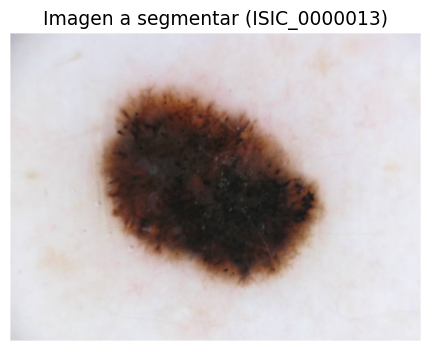

In [5]:
img_dir = "Subconjunto_2018/images/"
mask_dir = "Subconjunto_2018/masks/"
csv_dir = "Subconjunto_2018/"

files = os.listdir(img_dir)
i = np.random.randint(0,len(files)) # Tomo un entero al azar

img_name = files[i] # Dado dicho entero, elijo una imagen al azar

img = imread(img_dir+img_name) # Leo la imagen
img_seg_true = imread(mask_dir+img_name[:-4]+'_Segmentation.png')

plt.figure(figsize=(6,4))
plt.title('Imagen a segmentar ('+img_name[:-4]+')', fontsize=13.5)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

Finalmente, segmentamos la imagen y mostramos el resultado. En las figuras, a la derecha, se incluye la superposición de ambas segmentaciones. En amarillo es la región donde ambas convergen.

Índice de Jaccard: 0.8991


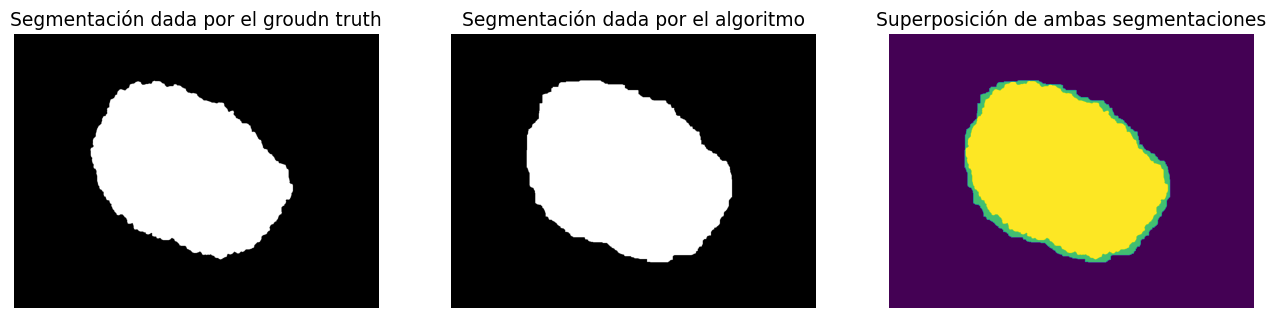

In [6]:
seg_alg = segmentar(img)

mascara_superpuesta = cv2.addWeighted(seg_alg, 0.7, img_seg_true, 0.3, 0.0)

print('Índice de Jaccard:', np.round(jaccard_score(img_seg_true.flatten(), seg_alg.flatten(), pos_label=255),4))

plt.figure(figsize=(16,12))
plt.subplot(1,3,1)
plt.title('Segmentación dada por el groudn truth', fontsize=13.5)
plt.imshow(img_seg_true, cmap='gray')
plt.axis('off')


plt.subplot(1,3,2)
plt.title('Segmentación dada por el algoritmo', fontsize=13.5)
plt.imshow(seg_alg, cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.title('Superposición de ambas segmentaciones', fontsize=13.5)
plt.imshow(mascara_superpuesta)
plt.axis('off')
plt.show()